In [2]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

In [3]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 20
latent_dim = 3
mnist_class_anomaly = 0
fuzzy_rules_count = 3*5
beta = 1e-1
gamma = 1

prefix = f"fuzzy_cvae_mamdani_anomaly"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [4]:
def random_noise_to_img(data, noise_level=0.01):
    rdata = torch.rand_like(data)
    return torch.where(rdata > noise_level, data,0.5)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

augmentation = v2.Compose([
    #v2.RandomRotation(2, fill=-0.5),
    #v2.RandomErasing(p=0.5, scale=(0.02, 0.09), value=-0.5),
    v2.Lambda(lambda y: random_noise_to_img(y, 0.03)),
    v2.GaussianBlur(11),
    v2.Grayscale(1),
])

In [6]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54077

загружаем тестовую выборку

In [7]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [8]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

tensor(0.4968)
tensor(-0.5000)


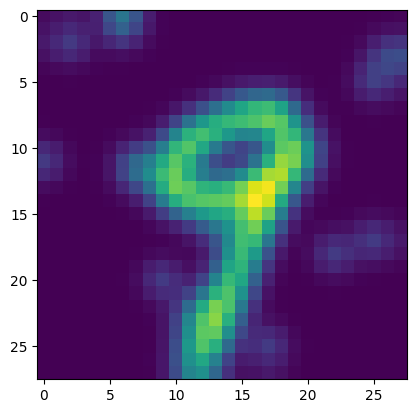

In [9]:
for data,_ in iter(train_loader):
    plt.imshow(augmentation(data)[0].squeeze())
    print(augmentation(data)[0].max())
    print(augmentation(data)[0].min())
    break

## Модель

Модель представляет собой VAE с набором дополнительного инференса над латентным слоем для предсказания ошибки реконструкции

In [10]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [732]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [733]:
class ADFVAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim):
        super(ADFVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        initial_centroids = np.random.rand(fuzzy_rules_count, latent_dim)
        initial_scales = 1e-2 * np.ones((fuzzy_rules_count, latent_dim))
        self.fuzzy = nn.Sequential(
            FuzzyBellLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True),
            DefuzzyLinearLayer.from_array(np.repeat([1.0,  0.0, -1.0], fuzzy_rules_count/3).reshape(1, -1), with_norm=False, trainable=False)
        )

    def forward(self, x):
        """
        
        """
        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        fz = self.fuzzy(mu)
        
        return mu, x_recon, fz.squeeze()
    
    def half_pass(self, x):
        """
        
        """
        mu, logvar, z = self.encoder(x)
        fz = self.fuzzy(mu)
        return mu, logvar, z, fz.squeeze()
    
    def decoder_pass(self, x):
        return self.decoder(x)


## Обучение

In [734]:
model = ADFVAE(latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,692,284


ADFVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=6, bias=True)
    )
    (softplus): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=3, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [735]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [736]:
ssim = piqa.SSIM(window_size=11, n_channels=1, reduction='none').to(device)

def compute_loss(x, recon_x, mu, logvar, fz):
    
    diff = ssim(x + 0.5, recon_x)
    fz_loss = (diff - fz).square().mean() #

    loss_recon = (1 - diff).square().mean() #F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()#
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
    
    loss = loss_recon + beta * loss_kl + gamma * fz_loss

    return loss, loss_recon, loss_kl, fz_loss
    

In [737]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [738]:
# inp = (torch.rand((10, 1, 28, 28))-0.5).to(device)
# mu, logvar, z, fz = model.half_pass(inp)
# recon_x = model.decoder_pass(z)
# mu2,_,_,_ = model.half_pass(recon_x)
# loss, loss_recon, loss_kl, fz_loss = compute_loss(inp, recon_x, mu, logvar, fz)
# fz_loss

In [739]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        adata = augmentation(data).to(device)
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logvar, z, fz = model.half_pass(adata)  
        recon_x = model.decoder_pass(z)
        
        loss, _, _, _ = compute_loss(data, recon_x, mu, logvar, fz)
        
        ev_loss = keep_eigenvals_positive_loss(model.fuzzy[0])
        if ev_loss.item() > 0:
            loss.backward(retain_graph=True)
            ev_loss.backward()
        else:
            loss.backward()
                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [740]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_recon_loss = 0
    test_kl_loss = 0
    test_fz_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            mu, logvar, z, fz = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            
            _, loss_recon, loss_kl, fz_loss = compute_loss(data, recon_x, mu, logvar, fz)
                    
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fz_loss += fz_loss.item()

    
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f}, FZ: {test_fz_loss:.4f}')
    
    if writer is not None:
        
        writer.add_scalar('ADFVAE/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/KLD', test_kl_loss, global_step=cur_step)
        writer.add_scalar('ADFVAE/Fuzzy', test_fz_loss, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('ADFVAE/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [741]:
prev_updates = 0
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


[212] Reconstruction loss: 0.3567, KLD: 1.6231, FZ: 0.0178
[424] Reconstruction loss: 0.3307, KLD: 1.5029, FZ: 0.0180
[636] Reconstruction loss: 0.3206, KLD: 1.4385, FZ: 0.0188
[848] Reconstruction loss: 0.3129, KLD: 1.5882, FZ: 0.0184
[1060] Reconstruction loss: 0.3042, KLD: 1.6809, FZ: 0.0188
[1272] Reconstruction loss: 0.3041, KLD: 1.5410, FZ: 0.0178
[1484] Reconstruction loss: 0.2945, KLD: 1.5382, FZ: 0.0170
[1696] Reconstruction loss: 0.2893, KLD: 1.6097, FZ: 0.0177
[1908] Reconstruction loss: 0.2877, KLD: 1.5845, FZ: 0.0166
[2120] Reconstruction loss: 0.2917, KLD: 1.5414, FZ: 0.0175
[2332] Reconstruction loss: 0.2888, KLD: 1.5968, FZ: 0.0178
[2544] Reconstruction loss: 0.2847, KLD: 1.5880, FZ: 0.0187
[2756] Reconstruction loss: 0.2906, KLD: 1.5638, FZ: 0.0180
[2968] Reconstruction loss: 0.2879, KLD: 1.5548, FZ: 0.0164
[3180] Reconstruction loss: 0.2786, KLD: 1.5975, FZ: 0.0167
[3392] Reconstruction loss: 0.2817, KLD: 1.6168, FZ: 0.0178
[3604] Reconstruction loss: 0.2926, KLD: 1.4

In [742]:
model.fuzzy[0].get_transformation_matrix_eigenvals().real.min()

tensor(0.0054, device='cuda:0', grad_fn=<MinBackward1>)

## Исследуем сходимость

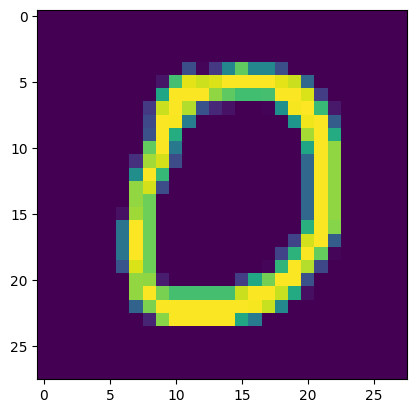

In [743]:
target_index = 10
plt.imshow(test_data[target_index][0].squeeze().cpu().numpy())

tensor(0.0127, device='cuda:0')
tensor(0.0062, device='cuda:0')
tensor(0.0034, device='cuda:0')
tensor(0.0021, device='cuda:0')
tensor(0.0011, device='cuda:0')


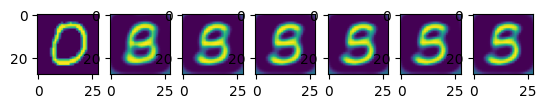

In [744]:
with torch.no_grad():
    plt.subplot(1, 7, 1)
    plt.imshow(test_data[target_index][0].squeeze().cpu().numpy())
    mu, x_recon, _ = model.forward(test_data[target_index][0].reshape(1,1,28,28).to(device))
    plt.subplot(1, 7, 2)
    plt.imshow(x_recon.squeeze().cpu().numpy())
    mu2, x_recon, _ = model.forward((x_recon-0.5).reshape(1,1,28,28))
    plt.subplot(1, 7, 3)
    plt.imshow(x_recon.squeeze().cpu().numpy())
    mu3, x_recon, _ = model.forward((x_recon-0.5).reshape(1,1,28,28))
    plt.subplot(1, 7, 4)
    plt.imshow(x_recon.squeeze().cpu().numpy())
    mu4, x_recon, _ = model.forward((x_recon-0.5).reshape(1,1,28,28))
    plt.subplot(1, 7, 5)
    plt.imshow(x_recon.squeeze().cpu().numpy())
    mu5, x_recon, _ = model.forward((x_recon-0.5).reshape(1,1,28,28))
    plt.subplot(1, 7, 6)
    plt.imshow(x_recon.squeeze().cpu().numpy())
    mu6, x_recon, _ = model.forward((x_recon-0.5).reshape(1,1,28,28))
    plt.subplot(1, 7, 7)
    plt.imshow(x_recon.squeeze().cpu().numpy())
    
    print((mu-mu2).square().sum())
    print((mu3-mu2).square().sum())
    print((mu3-mu4).square().sum())
    print((mu4-mu5).square().sum())
    print((mu5-mu6).square().sum())
    

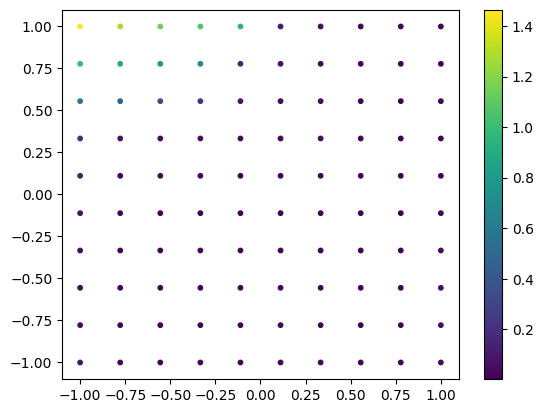

In [745]:
def density(x, y):
    with torch.no_grad():
        z = np.repeat(0.0, latent_dim)
        z[0] = x
        z[1] = y
        z = torch.FloatTensor(z).reshape(1, latent_dim).to(device)
        recon_x = model.decoder_pass(z)
        mu,_,_,_ = model.half_pass(recon_x)
        return (z-mu).square().sum().item()

nx, ny = (10, 10)
xx = np.linspace(-1, 1, nx)
yy = np.linspace(-1, 1, ny)

costs = []
for x in xx:
    for y in yy:
        D = density(x, y)
        costs.append([x,y, D])

plt.scatter([a[0] for a in costs], [a[1] for a in costs], c=[a[2] for a in costs], s=10) 
plt.colorbar()


## Визуализируем результаты

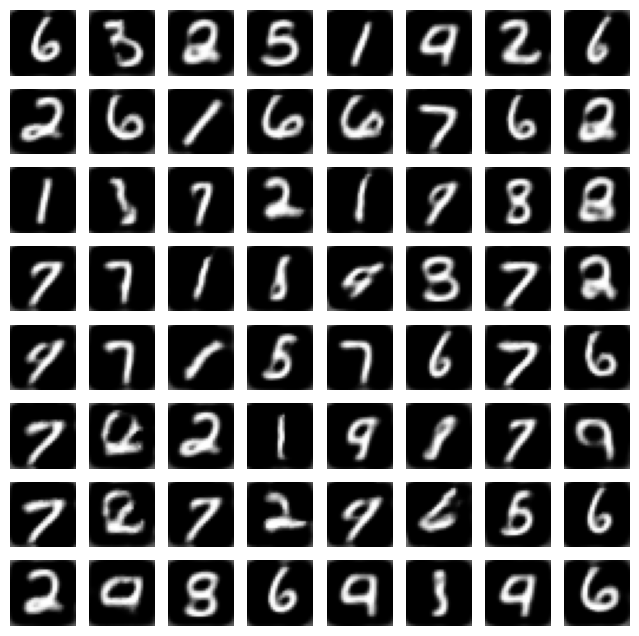

In [746]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [747]:
def get_arate(inp):
    mu, logvar, z, fz = model.half_pass(inp)
    
    return fz.squeeze().cpu().numpy()


MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

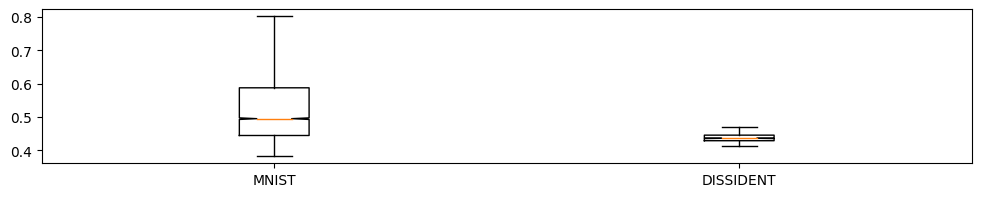

In [748]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

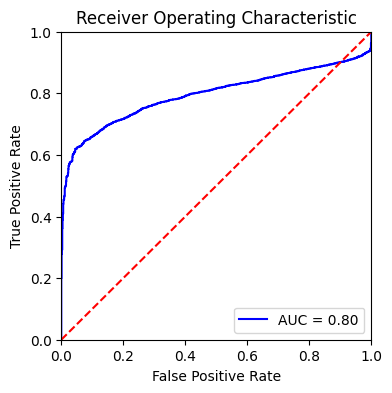

In [749]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(0)
            else:
                lab_true.append(1)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

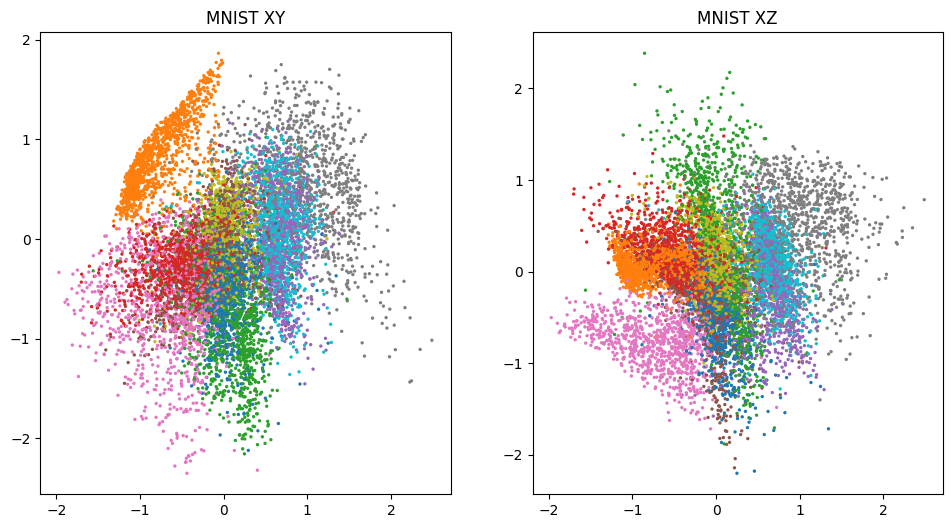

In [750]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding,_,_ = model.forward(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

plt.figure(figsize=(18, 6))

R, C = 1, 3

plt.subplot(R, C, 1)
plt.title("MNIST XY")
plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.subplot(R, C, 2)
plt.title("MNIST XZ")
plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)


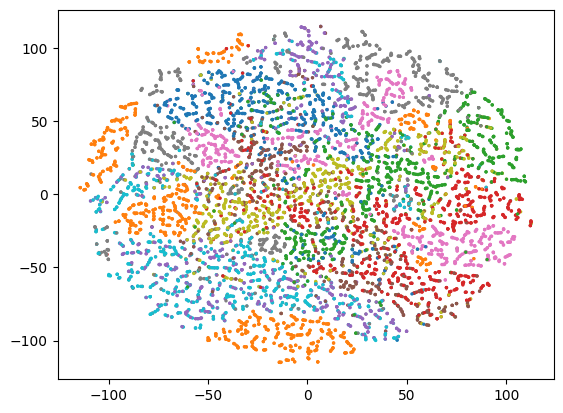

In [751]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embedings)
plt.scatter(X_embedded[:, 0],      X_embedded[:,  1], c=labels_expected, cmap='tab10', s=2)

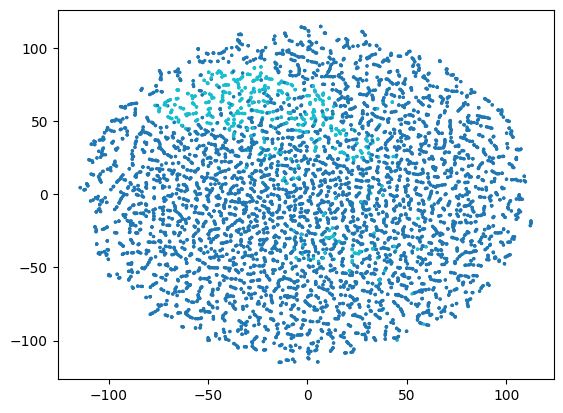

In [752]:
plt.scatter(X_embedded[:, 0],      X_embedded[:,  1], c=[a == mnist_class_anomaly for a in labels_expected] , cmap='tab10', s=2)